In [1]:
# Setup the library
import pyrogue as pr
import os, sys
import matplotlib.pyplot as plt
import time
import numpy as np
import math

from scipy import stats
from scipy.optimize import curve_fit
from scipy.stats import norm


top_level=f'{os.getcwd()}/../../../'
pr.addLibraryPath( f'{top_level}/scripts' )
import setupLibPaths
import epix_hr_single_10k
import ePixViewer.Cameras as cameras

%run ../../ASIC_V4/supportFunctions.ipynb

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [2]:
# Create and start the root class
root = epix_hr_single_10k.RootLCLSIITiming(
    top_level   = top_level,
    sim         = False,
    dev         = '/dev/datadev_0',
    asicVersion = 4
)
root.start()

Simulation mode : False
Start: Started zmqServer on ports 9099-9101
    To start a gui: python -m pyrogue gui --server='localhost:9099'
    To use a virtual client: client = pyrogue.interfaces.VirtualClient(addr='localhost', port=9099)


In [3]:
# Create useful pointers
AxiVersion = root.Core.AxiVersion
print ( '###################################################')
print ( '#             Firmware Version                    #')
print ( '###################################################')
AxiVersion.printStatus()
print ( '###################################################')

###################################################
#             Firmware Version                    #
###################################################
Path         = ePixHr10kT.Core.AxiVersion
FwVersion    = 0x3010000
UpTime       = 2 days, 11:17:58
GitHash      = 0x563a68027652195474e6a610098a11775111615a
XilinxDnaId  = 0x4002000101604ee71c61a3c5
FwTarget     = EpixHr10kTLclsIITiming
BuildEnv     = Vivado v2022.2
BuildServer  = rdsrv408 (Ubuntu 20.04.6 LTS)
BuildDate    = Thu 02 Nov 2023 02:16:58 PM PDT
Builder      = ddoering
###################################################


# Helper functions

In [4]:
# Define the linear function
def linear_function(x, a, b):
    return a * x + b

def getResidualsLinFit(x,y):
    
    weights = np.exp(-(x - np.mean(x))**2 / (2 * np.std(x)**2))
    params, covariance = curve_fit(linear_function, x, y, sigma=1/weights, absolute_sigma=True)
    y_fit = linear_function(x, *params)
   
    return (y - y_fit)

def getGainLinFit(x,y):
    
    weights = np.exp(-(x - np.mean(x))**2 / (2 * np.std(x)**2))
    params, covariance = curve_fit(linear_function, x, y, sigma=1/weights, absolute_sigma=True)
    y_fit = linear_function(x, *params)
   
    return params[0]

# Initialization

In [5]:
MAX_NUMBER_OF_FRAMES_PER_BATCH  = 1000
cameraType            = 'ePixHr10kTBatcher'
bitMask               = 0xffff
currentCam = cameras.Camera(cameraType = cameraType)
currentCam.bitMask = bitMask

Camera  ePixHr10kTBatcher  selected.


In [6]:
#Initialze the camera
#[routine, asic0, asic1, asic2, asic3]'
initSequence = 5
root.EpixHR.InitASIC([initSequence,0,0,1,0])
#points to the ASIC device under test
ASIC = root.EpixHR.Hr10kTAsic2
root.EpixHR.BatcherEventBuilder0.Blowoff.set(True)
root.EpixHR.BatcherEventBuilder0.Bypass.set(1)
root.EpixHR.BatcherEventBuilder1.Blowoff.set(False)
root.EpixHR.BatcherEventBuilder1.Bypass.set(1)
root.EpixHR.BatcherEventBuilder2.Blowoff.set(True)

Rysync ASIC started
Init ASIC script started
Loading MMCM configuration
/u3/ePix10k/epix-hr-single-10k/software/notebooks/Lorenzo/Pixel/../../..//yml/ePixHr10kT_MMCM_320MHz.yml
Completed
Loading supply configuration
/u3/ePix10k/epix-hr-single-10k/software/notebooks/Lorenzo/Pixel/../../..//yml/ePixHr10kT_PowerSupply_Enable.yml
Loading register control (waveforms) configuration
/u3/ePix10k/epix-hr-single-10k/software/notebooks/Lorenzo/Pixel/../../..//yml/ePixHr10kT_RegisterControl_R0Width12us_AcqWidth24us_320MHz.yml
Loading packet registers
Disabling packet lanes for ASIC 0
Disabling packet lanes for ASIC 1
Disabling packet lanes for ASIC 3
/u3/ePix10k/epix-hr-single-10k/software/notebooks/Lorenzo/Pixel/../../..//yml/ePixHr10kT_PacketRegisters.yml
Taking asic off of reset
Loading ASIC and timing configuration
Loading  /u3/ePix10k/epix-hr-single-10k/software/notebooks/Lorenzo/Pixel/../../..//yml/ePixHr10kT_PLLBypass_248MHz_ASIC_2.yml
Command executed :  <class 'pyrogue._Command.BaseComman

In [7]:
#Makes sure triggers are off
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.1)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(True)
time.sleep(10)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.1)

#use system with batcher and missing ASICs
root.EpixHR.SspLowSpeedDecoderReg.enable.set(True)
print ("Locked lanes: %x" % root.EpixHR.SspLowSpeedDecoderReg.Locked.get())
#Only ASIC 1 is available so disable the 6 lower lanes
root.EpixHR.PacketRegisters0.DisableLane.set(0x3FF)
root.EpixHR.PacketRegisters1.DisableLane.set(0xFC0)

Locked lanes: 3f000


In [8]:
# Set pixel configuration
pixelList = [[10, 10, 1],[10, 42, 5],[42, 10, 9],[42, 42, 13]]
pixelOffset = 0
pixelListRB = [[20, 30+pixelOffset, 1],[20, 35+pixelOffset, 5],[20, 40+pixelOffset, 9],[20, 45+pixelOffset, 13]]
for i in range(len(pixelList)):
    print(f'\nPixel [%d, %d]' %(pixelList[i][0], pixelList[i][1]))
    print (f'Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): %d' % readPixelConfig(ASIC, pixelList[i][0], pixelList[i][1]))
    print (f'Writing individula pixel')
    writedPixelConfig(ASIC, pixelList[i][0], pixelList[i][1], pixelList[i][2])
    print (f'Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): %d' % readPixelConfig(ASIC, pixelList[i][0], pixelList[i][1]))

for i in range(192):    
    writedPixelConfig(ASIC, 25, i, 1)



Pixel [10, 10]
Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): 0
Writing individula pixel
Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): 1

Pixel [10, 42]
Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): 0
Writing individula pixel
Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): 5

Pixel [42, 10]
Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): 0
Writing individula pixel
Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): 9

Pixel [42, 42]
Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): 0
Writing individula pixel
Pixel setting (0: AR, 4: forced switch, 8: fixed low, 12: fixed high): 13


In [19]:
#Makes sure triggers are off
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.2)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(True)
time.sleep(0.2)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.2)

# ------------------------------------ ADC
# Disable external DAC
ASIC.mTest.set(False)

# ADC settings
ASIC.RefGenB.set(1) #2 bits
ASIC.RefGenC.set(2) #2 bits
ASIC.S2D_1_b.set(0) #3 bits
ASIC.shvc_DAC.set(30) #6 bits
ASIC.S2dDacBias.set(3)
ASIC.DHg.set(False)

# ------------------------------------ Pixel
# Set references 
Preamp     = 3 #4
Vld1_b     = 1 #1
Pixel_CB   = 4 #4
Filter_DAC = 24 #38
VRef_DAC   = 40 #53
CompTH_DAC = 28

# Write data
setPixel (Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC)
ASIC.CompTH_DAC.set(CompTH_DAC)

ASIC.CompEn.set(2)
ASIC.CompEnOn.set(True) 

# Set High Gain ----------------------------------------------------------
cfgHG = True

if cfgHG==True:
    gainCfg = 'HG'
else:
    gainCfg = 'MG'

ASIC.trbit.set(cfgHG) # high/medium gain
print (f'Check trbit (0: medium gain, 1: high gain): %d' % ASIC.trbit.get())


# ------------------------------------ Pulser for Charge injection
ASIC.PulserR.set(True)
ASIC.PulserR.set(False)
ASIC.MonostPulser.set(7)

# Configure Pulser Ch. Injection
ASIC.test.set(True)
ASIC.atest.set(True)

######################################################################################################################
# Remove previous dataset
filename = (f'/u1/lorenzor/10kthr_data/temp.dat')

Preamp 3
Vld1_b 1
Pixel_CB 4
Filter_DAC 24
VRef_DAC 40
Check trbit (0: medium gain, 1: high gain): 1


# Parameter sweep


In [20]:
# PixRow / Col
pixRow = 10
pixCol = 10

# Always reset the pulser, so we run from same start/stop
ASIC.PulserR.set(True)
ASIC.PulserR.set(False)
dataOpt = run_asic_test(numFrames = 2000, initialDelay = 0)[:1000,pixRow,pixCol];

/u1/lorenzor/10kthr_data/temp.dat
Aquisition Counter 1197283
DAQ Counter 1172153
Number of frames received: 0
Delta Aquisition Counter: 2001
Number of frames received: 2001
Starting to get data set 0
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
(1000, 56072)


In [21]:
# Bit operations
gainbit = np.bitwise_and(dataOpt.astype(int), 0x8000) >> 15
data = np.bitwise_and(dataOpt, 0x3FFF)

In [22]:
# Fit and calculate gain
# Create arbitrary array to do the fitting against
pulserValues = np.arange(np.shape(data)[0])

# Create masks for HG (or MG) and LG
HG = gainbit==0
LG = gainbit==1

# Fit the two gains
gain_HG = getGainLinFit(pulserValues[HG], data[HG])
try:
    gain_LG = getGainLinFit(pulserValues[LG], data[LG])
except:
    print('No Gain switching found')
    gain_LG = 0

# Get residuals
resHG = getResidualsLinFit(pulserValues[HG], data[HG])
try:
    resLG = getResidualsLinFit(pulserValues[LG], data[LG])
except:
    print('No Gain switching found')
    resLG = 0
    
print('Gain HG:', gain_HG)
print('Gain LG:', gain_LG)
print('Gain Ratio', gain_HG/gain_LG)

Gain HG: 30.058889054435785
Gain LG: 0.4856842511900317
Gain Ratio 61.889775056088375


HG


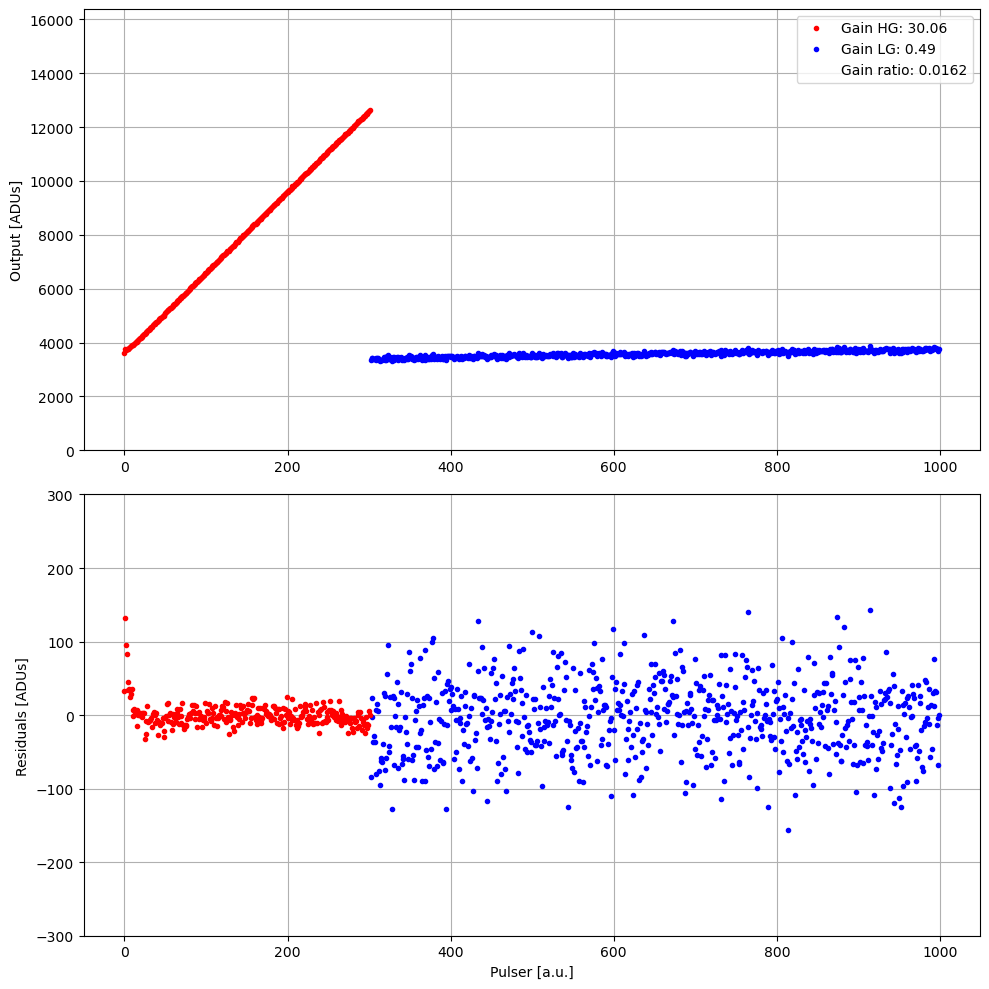

In [23]:
# Create figure
fig=plt.figure(figsize=(10,10))
ax1 = plt.subplot(211)
ax2 = plt.subplot(212, sharex = ax1)

print(gainCfg)

# Plot data
ax1.plot(pulserValues[HG],data[HG],'.',color='red', label=('Gain ' + gainCfg + ': {:.2f}'.format(gain_HG)))
try:
    ax1.plot(pulserValues[LG],data[LG],'.',color='blue', label='Gain LG: {:.2f}'.format(gain_LG))
    ax1.plot([], [], ' ', label='Gain ratio: {:.4f}'.format(gain_LG/gain_HG))
    ax2.plot(pulserValues[gainbit==1],resLG,'.',color='blue')
except:
    print()
ax1.set_ylabel('Output [ADUs]')
ax1.legend()
ax1.set_ylim(0,2**14)
ax1.grid()

ax2.plot(pulserValues[gainbit==0],resHG,'.',color='red')
ax2.set_ylabel('Residuals [ADUs]')
ax2.set_xlabel('Pulser [a.u.]')
ax2.set_ylim(-300,300)
ax2.grid()

plt.tight_layout()
